# Egyptian Currency Classification using CNN
## Problem Description
This project classifies Egyptian banknotes (1, 5, 10, 20, 50, 100, 200 EGP) using a custom CNN built from scratch.
No transfer learning or pre-trained models are used.


## 1. Import Required Libraries

In [2]:
import os
import numpy as np
import tensorflow as tf
from math import ceil
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import (Conv2D, MaxPooling2D, Flatten, Dense,
                                      BatchNormalization, Dropout, Input)
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.utils.class_weight import compute_class_weight
import matplotlib.pyplot as plt
from PIL import Image
import seaborn as sns
# Try importing seaborn; fall back if unavailable
try:
    import seaborn as sns
    sns.set_theme(style='white', context='notebook', palette='deep')
except Exception:
    sns = None

# Set random seeds for reproducibility
np.random.seed(42)
tf.random.set_seed(42)


## 2. Configure Paths and Parameters

In [3]:
BASE_PATH = os.path.join(os.getcwd(), 'dataset')
IMG_SIZE = (96, 96)    # Smaller images - better for limited data, faster training
BATCH_SIZE = 32        # Smaller batch for better generalization with limited data
NUM_EPOCHS = 100       # More epochs - early stopping will handle it

train_dir = os.path.join(BASE_PATH, 'train')
val_dir = os.path.join(BASE_PATH, 'valid')
test_dir = os.path.join(BASE_PATH, 'test')

print(f"Training directory: {train_dir}")
print(f"Validation directory: {val_dir}")
print(f"Test directory: {test_dir}")


Training directory: /Users/karim/PycharmProjects/JupyterProject3/dataset/train
Validation directory: /Users/karim/PycharmProjects/JupyterProject3/dataset/valid
Test directory: /Users/karim/PycharmProjects/JupyterProject3/dataset/test


## 3. Explore the Dataset

In [4]:
# Count images per class
def count_images_per_class(directory):
    class_counts = {}
    for class_name in sorted(os.listdir(directory)):
        class_path = os.path.join(directory, class_name)
        if os.path.isdir(class_path):
            count = len([f for f in os.listdir(class_path)
                        if f.lower().endswith(('.jpg', '.jpeg', '.png'))])
            class_counts[class_name] = count
    return class_counts

train_counts = count_images_per_class(train_dir)
print("Training set class distribution:")
for cls, count in train_counts.items():
    print(f"  Class {cls}: {count} images")
print(f"\nTotal training images: {sum(train_counts.values())}")


Training set class distribution:
  Class 1: 60 images
  Class 10: 315 images
  Class 10 (new): 317 images
  Class 100: 315 images
  Class 20: 322 images
  Class 20 (new): 346 images
  Class 200: 313 images
  Class 5: 334 images
  Class 50: 315 images

Total training images: 2637


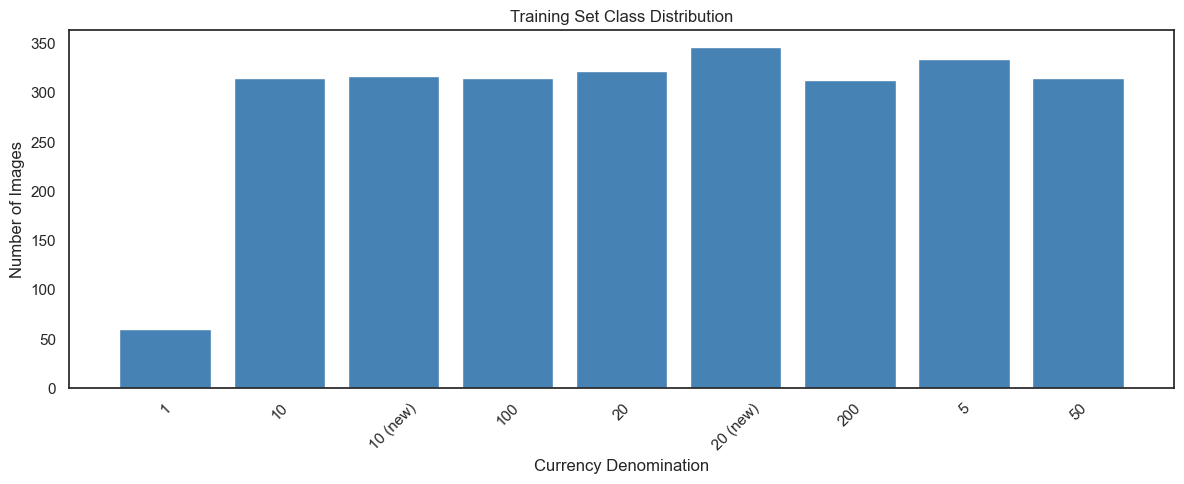

In [5]:
# Visualize class distribution
plt.figure(figsize=(12, 5))
classes = list(train_counts.keys())
counts = list(train_counts.values())
plt.bar(classes, counts, color='steelblue')
plt.xlabel('Currency Denomination')
plt.ylabel('Number of Images')
plt.title('Training Set Class Distribution')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


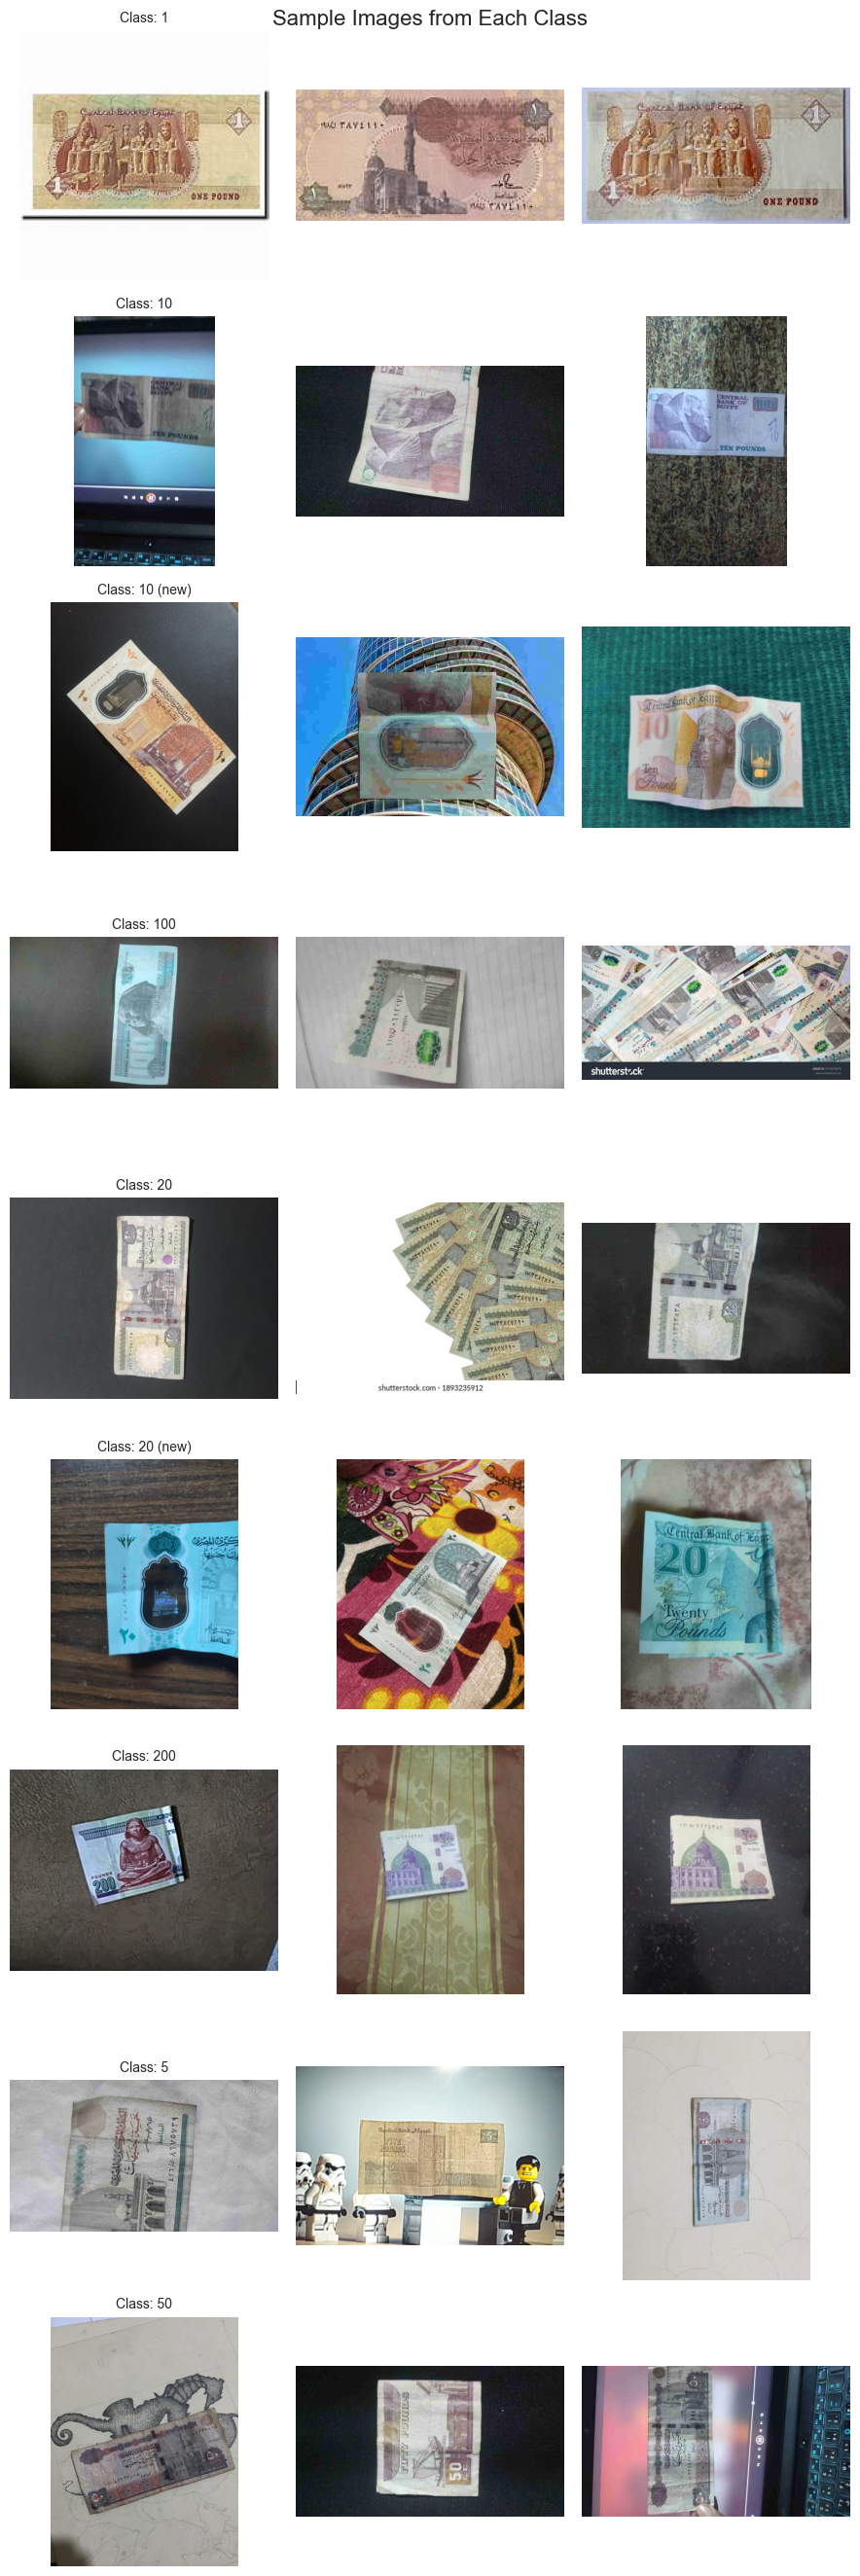

In [6]:
# Display sample images from each class
def display_sample_images(directory, num_samples=3):
    class_names = sorted([d for d in os.listdir(directory) if os.path.isdir(os.path.join(directory, d))])
    num_classes = len(class_names)

    fig, axes = plt.subplots(num_classes, num_samples, figsize=(num_samples*3, num_classes*3))
    fig.suptitle('Sample Images from Each Class', fontsize=16)

    for i, class_name in enumerate(class_names):
        class_path = os.path.join(directory, class_name)
        images = [f for f in os.listdir(class_path) if f.lower().endswith(('.jpg', '.jpeg', '.png'))][:num_samples]

        for j, img_name in enumerate(images):
            img_path = os.path.join(class_path, img_name)
            img = Image.open(img_path).convert('RGB')

            if num_classes > 1:
                axes[i, j].imshow(img)
                axes[i, j].axis('off')
                if j == 0:
                    axes[i, j].set_title(f'Class: {class_name}', fontsize=10)
            else:
                axes[j].imshow(img)
                axes[j].axis('off')

    plt.tight_layout()
    plt.show()

display_sample_images(train_dir, num_samples=3)


Sample image from class '1'
Image shape: (201, 201, 3)
Pixel value range: [0, 255]


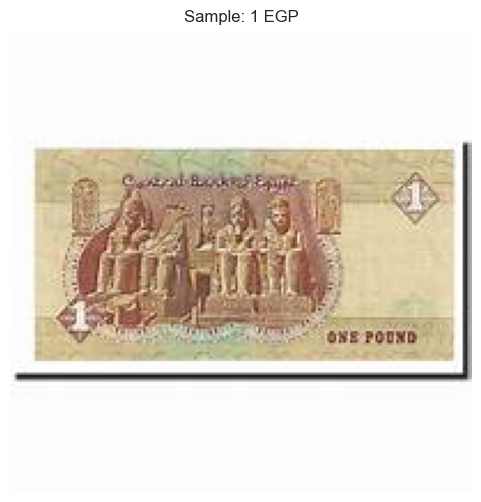

In [7]:
# Display a single image with pixel info (similar to MNIST example)
sample_class = list(train_counts.keys())[0]
sample_path = os.path.join(train_dir, sample_class)
sample_img_name = [f for f in os.listdir(sample_path) if f.lower().endswith(('.jpg', '.jpeg', '.png'))][0]
sample_img = Image.open(os.path.join(sample_path, sample_img_name)).convert('RGB')
sample_array = np.array(sample_img)

print(f"Sample image from class '{sample_class}'")
print(f"Image shape: {sample_array.shape}")
print(f"Pixel value range: [{sample_array.min()}, {sample_array.max()}]")

plt.figure(figsize=(6, 6))
plt.imshow(sample_img)
plt.title(f'Sample: {sample_class} EGP')
plt.axis('off')
plt.show()


## 4. Create Data Generators with Strong Augmentation

In [8]:
# Strong but realistic augmentation for currency classification
# This helps the model generalize better with limited training data
train_datagen = ImageDataGenerator(
    rescale=1.0/255,
    rotation_range=20,              # Moderate rotation for real-world scenarios
    width_shift_range=0.15,         # Shift for position invariance
    height_shift_range=0.15,
    shear_range=0.15,               # Slight perspective distortion
    zoom_range=0.2,                 # Zoom for scale invariance
    horizontal_flip=False,          # IMPORTANT: Don't flip currency notes!
    brightness_range=[0.7, 1.3],    # Stronger brightness variation for different lighting
    channel_shift_range=30,         # Color variation for different lighting conditions
    fill_mode='nearest'
)

# Only rescale for validation/test
val_datagen = ImageDataGenerator(rescale=1.0/255)


## 5. Load Data from Directories

In [9]:
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=True
)

val_generator = val_datagen.flow_from_directory(
    val_dir,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False
)

test_generator = val_datagen.flow_from_directory(
    test_dir,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False
)

num_classes = len(train_generator.class_indices)
print(f"\nNumber of classes: {num_classes}")
print(f"Class mapping: {train_generator.class_indices}")
print(f"Training samples: {train_generator.samples}")
print(f"Validation samples: {val_generator.samples}")
print(f"Test samples: {test_generator.samples}")


Found 2637 images belonging to 9 classes.
Found 760 images belonging to 9 classes.
Found 290 images belonging to 9 classes.

Number of classes: 9
Class mapping: {'1': 0, '10': 1, '10 (new)': 2, '100': 3, '20': 4, '20 (new)': 5, '200': 6, '5': 7, '50': 8}
Training samples: 2637
Validation samples: 760
Test samples: 290


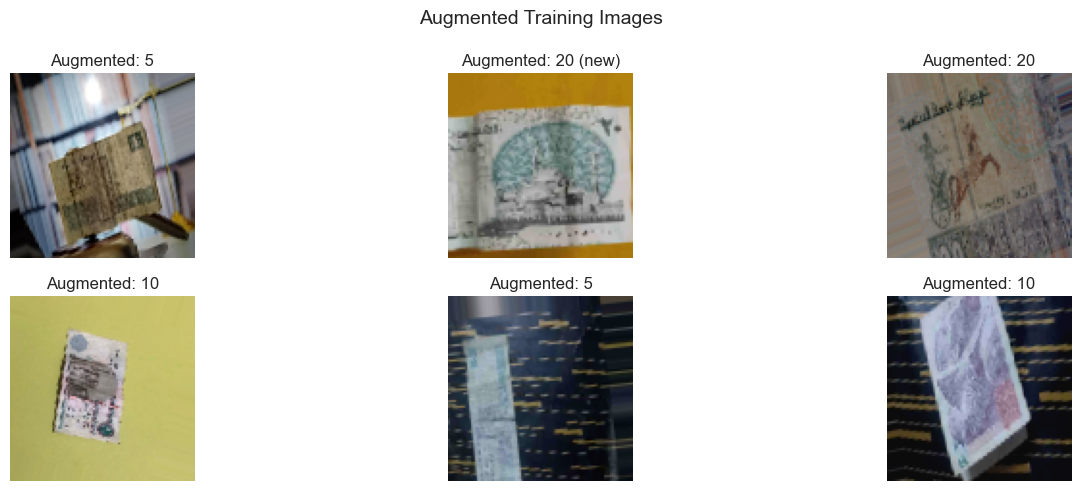

In [10]:
# Display augmented samples
def show_augmented_images(generator, num_images=6):
    """Display augmented training images"""
    plt.figure(figsize=(15, 5))
    batch = next(generator)
    images, labels = batch[0][:num_images], batch[1][:num_images]

    class_names = list(generator.class_indices.keys())

    for i in range(num_images):
        plt.subplot(2, 3, i + 1)
        plt.imshow(images[i])
        label_idx = np.argmax(labels[i])
        plt.title(f'Augmented: {class_names[label_idx]}')
        plt.axis('off')

    plt.suptitle('Augmented Training Images', fontsize=14)
    plt.tight_layout()
    plt.show()

show_augmented_images(train_generator)


## 6. Compute Class Weights (Handle Imbalanced Data)

In [11]:
# Compute class weights to handle any class imbalance
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(train_generator.classes),
    y=train_generator.classes
)
class_weight_dict = dict(enumerate(class_weights))
print("Class weights:", class_weight_dict)


Class weights: {0: np.float64(4.883333333333334), 1: np.float64(0.9301587301587302), 2: np.float64(0.9242902208201893), 3: np.float64(0.9301587301587302), 4: np.float64(0.9099378881987578), 5: np.float64(0.846820809248555), 6: np.float64(0.9361022364217252), 7: np.float64(0.8772455089820359), 8: np.float64(0.9301587301587302)}


## 7. Setup Callbacks

In [12]:
callbacks = [
    ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,              # Reduce LR by half
        patience=8,              # More patience before reducing LR
        min_lr=1e-7,
        verbose=1
    ),
    EarlyStopping(
        monitor='val_loss',
        patience=25,             # Much more patience - allow model to fully converge
        restore_best_weights=True,
        verbose=1
    ),
    ModelCheckpoint(
        'best_currency_model.keras',
        monitor='val_accuracy',
        save_best_only=True,
        verbose=1
    )
]


## 8. Build the CNN Model
### Architecture Description
Our CNN uses a **simpler architecture with stronger regularization** to prevent overfitting:
- **3 Convolutional Blocks** (reduced from 4) - prevents overfitting on limited data
- **L2 Regularization** on all Conv2D and Dense layers - penalizes large weights
- **Higher Dropout rates** (0.3 in conv blocks, 0.5 in dense) - stronger regularization
- **Fewer dense neurons** (256 instead of 512) - reduces model complexity

Architecture: `Input -> [[Conv2D->BN->ReLU]*2 -> MaxPool -> Dropout]*3 -> Flatten -> Dense -> Dropout -> Output`


In [13]:

def build_currency_cnn(input_shape, num_classes):
    """
    Build a SIMPLER CNN optimized for Egyptian currency classification.
    Uses stronger regularization to prevent overfitting on limited data.
    """
    # L2 regularization factor
    reg = l2(0.001)

    model = Sequential([
        # Input layer
        Input(shape=input_shape),

        # Block 1: 32 filters - Low-level features (edges, colors)
        Conv2D(32, (3, 3), padding='same', activation='relu', kernel_regularizer=reg),
        BatchNormalization(),
        Conv2D(32, (3, 3), padding='same', activation='relu', kernel_regularizer=reg),
        BatchNormalization(),
        MaxPooling2D((2, 2)),
        Dropout(0.3),

        # Block 2: 64 filters - Mid-level features (textures, patterns)
        Conv2D(64, (3, 3), padding='same', activation='relu', kernel_regularizer=reg),
        BatchNormalization(),
        Conv2D(64, (3, 3), padding='same', activation='relu', kernel_regularizer=reg),
        BatchNormalization(),
        MaxPooling2D((2, 2)),
        Dropout(0.3),

        # Block 3: 128 filters - High-level features (currency details)
        Conv2D(128, (3, 3), padding='same', activation='relu', kernel_regularizer=reg),
        BatchNormalization(),
        Conv2D(128, (3, 3), padding='same', activation='relu', kernel_regularizer=reg),
        BatchNormalization(),
        MaxPooling2D((2, 2)),
        Dropout(0.4),

        # Fully Connected Layers - SIMPLIFIED
        Flatten(),
        Dense(256, activation='relu', kernel_regularizer=reg),
        BatchNormalization(),
        Dropout(0.5),
        Dense(num_classes, activation='softmax')
    ])

    return model

# Build the model
model = build_currency_cnn((IMG_SIZE[0], IMG_SIZE[1], 3), num_classes)
model.summary()


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 96, 96, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 96, 96, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 96, 96, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 96, 96, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 48, 48, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 48, 48, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 48, 48, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 48, 48, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 48, 48, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 48, 48, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 24, 24, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 24, 24, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 24, 24, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 24, 24, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 24, 24, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 24, 24, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 12, 12, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 12, 12, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 18432)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │     4,718,848 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼─────────────

 Total params: 5,010,985 (19.12 MB)

 Trainable params: 5,009,577 (19.11 MB)

 Non-trainable params: 1,408 (5.50 KB)

## 9. Compile the Model

In [14]:
# Use Adam optimizer with a lower learning rate for better convergence
optimizer = tf.keras.optimizers.Adam(learning_rate=5e-4)

model.compile(
    optimizer=optimizer,
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

print("Model compiled successfully!")
print(f"Optimizer: Adam (lr=0.0005)")
print(f"Loss: Categorical Crossentropy")
print(f"Metrics: Accuracy")


Model compiled successfully!
Optimizer: Adam (lr=0.0005)
Loss: Categorical Crossentropy
Metrics: Accuracy


## 10. Train the Model

In [15]:
steps_per_epoch = int(ceil(train_generator.samples / BATCH_SIZE))
validation_steps = int(ceil(val_generator.samples / BATCH_SIZE))

print(f"Steps per epoch: {steps_per_epoch}")
print(f"Validation steps: {validation_steps}")
print(f"Training for {NUM_EPOCHS} epochs...")

history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=NUM_EPOCHS,
    steps_per_epoch=steps_per_epoch,
    validation_steps=validation_steps,
    callbacks=callbacks,
    class_weight=class_weight_dict
)


Steps per epoch: 83
Validation steps: 24
Training for 100 epochs...
Epoch 1/100
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 593ms/step - accuracy: 0.1405 - loss: 3.8077
Epoch 1: val_accuracy improved from None to 0.10658, saving model to best_currency_model.keras
83/83 ━━━━━━━━━━━━━━━━━━━━ 57s 653ms/step - accuracy: 0.1706 - loss: 3.5282 - val_accuracy: 0.1066 - val_loss: 4.4049 - learning_rate: 5.0000e-04
Epoch 2/100
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 651ms/step - accuracy: 0.2615 - loss: 3.0789
Epoch 2: val_accuracy improved from 0.10658 to 0.10789, saving model to best_currency_model.keras
83/83 ━━━━━━━━━━━━━━━━━━━━ 59s 714ms/step - accuracy: 0.2605 - loss: 3.0916 - val_accuracy: 0.1079 - val_loss: 3.3254 - learning_rate: 5.0000e-04
Epoch 3/100
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 707ms/step - accuracy: 0.2861 - loss: 3.0108
Epoch 3: val_accuracy improved from 0.10789 to 0.11184, saving model to best_currency_model.keras
83/83 ━━━━━━━━━━━━━━━━━━━━ 64s 769ms/step - accuracy: 0.2814 - loss: 2.9750 - val_accura

## 11. Plot Training Curves

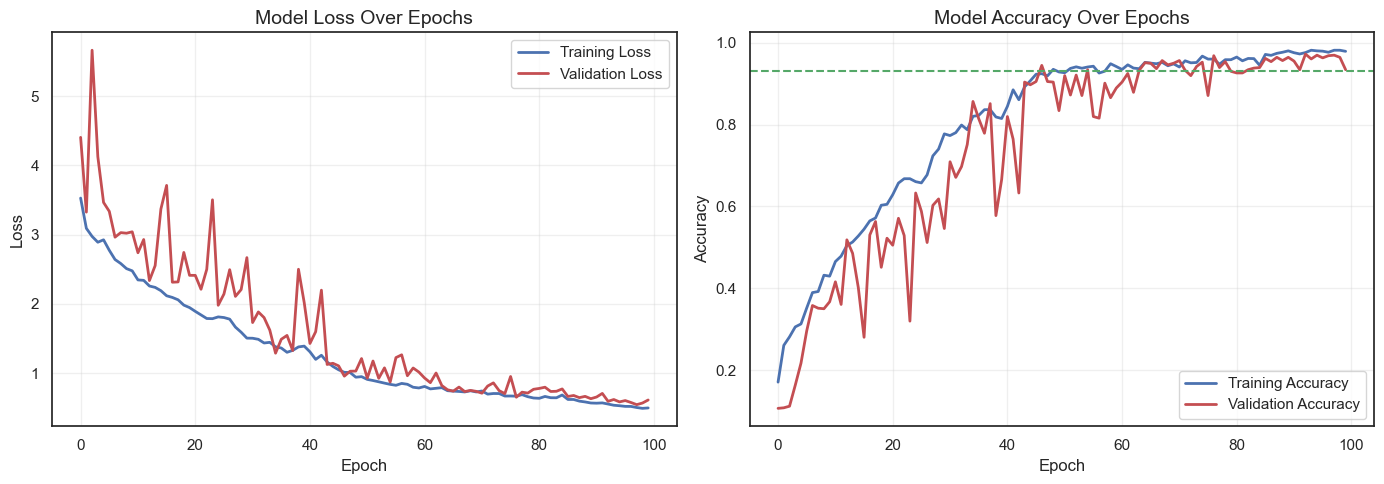


Final Training Accuracy: 97.91%
Final Validation Accuracy: 93.42%


In [16]:
def plot_training_history(history):
    """Plot training and validation loss/accuracy curves"""
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))

    # Loss plot
    axes[0].plot(history.history['loss'], 'b-', label='Training Loss', linewidth=2)
    axes[0].plot(history.history['val_loss'], 'r-', label='Validation Loss', linewidth=2)
    axes[0].set_title('Model Loss Over Epochs', fontsize=14)
    axes[0].set_xlabel('Epoch')
    axes[0].set_ylabel('Loss')
    axes[0].legend(loc='upper right')
    axes[0].grid(True, alpha=0.3)

    # Accuracy plot
    acc_key = 'accuracy' if 'accuracy' in history.history else 'acc'
    val_acc_key = 'val_accuracy' if 'val_accuracy' in history.history else 'val_acc'

    axes[1].plot(history.history[acc_key], 'b-', label='Training Accuracy', linewidth=2)
    axes[1].plot(history.history[val_acc_key], 'r-', label='Validation Accuracy', linewidth=2)
    axes[1].set_title('Model Accuracy Over Epochs', fontsize=14)
    axes[1].set_xlabel('Epoch')
    axes[1].set_ylabel('Accuracy')
    axes[1].legend(loc='lower right')
    axes[1].grid(True, alpha=0.3)
    axes[1].axhline(y=0.93, color='g', linestyle='--', label='Target: 93%')

    plt.tight_layout()
    plt.show()

    # Print final metrics
    final_train_acc = history.history[acc_key][-1]
    final_val_acc = history.history[val_acc_key][-1]
    print(f"\nFinal Training Accuracy: {final_train_acc*100:.2f}%")
    print(f"Final Validation Accuracy: {final_val_acc*100:.2f}%")

plot_training_history(history)


## 12. Evaluate the Model

In [17]:
# Evaluate on validation set
val_loss, val_acc = model.evaluate(val_generator, steps=validation_steps)
print(f"\nValidation Results:")
print(f"  Loss: {val_loss:.4f}")
print(f"  Accuracy: {val_acc*100:.2f}%")

# Evaluate on test set
test_steps = int(ceil(test_generator.samples / BATCH_SIZE))
test_loss, test_acc = model.evaluate(test_generator, steps=test_steps)
print(f"\nTest Results:")
print(f"  Loss: {test_loss:.4f}")
print(f"  Accuracy: {test_acc*100:.2f}%")

if test_acc >= 0.93:
    print(f"\n✅ SUCCESS: Achieved {test_acc*100:.2f}% accuracy (>93% target)")
else:
    print(f"\n⚠️  Current accuracy: {test_acc*100:.2f}% (Target: >93%)")


24/24 ━━━━━━━━━━━━━━━━━━━━ 6s 248ms/step - accuracy: 0.9697 - loss: 0.5459

Validation Results:
  Loss: 0.5459
  Accuracy: 96.97%
10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 251ms/step - accuracy: 0.9655 - loss: 0.5356

Test Results:
  Loss: 0.5356
  Accuracy: 96.55%

✅ SUCCESS: Achieved 96.55% accuracy (>93% target)


## 13. Generate Predictions and Classification Report

In [18]:
# Get class names in correct order
class_indices = train_generator.class_indices
class_names = [None] * len(class_indices)
for name, idx in class_indices.items():
    class_names[idx] = name

# Get true labels
y_true = val_generator.classes

# Get predictions
val_steps_for_pred = int(ceil(val_generator.samples / BATCH_SIZE))
y_pred_probs = model.predict(val_generator, steps=val_steps_for_pred)

# Trim predictions to match actual samples
if y_pred_probs.shape[0] > len(y_true):
    y_pred_probs = y_pred_probs[:len(y_true)]

y_pred = np.argmax(y_pred_probs, axis=1)

print('\n' + '='*60)
print('CLASSIFICATION REPORT')
print('='*60)
print(classification_report(y_true, y_pred, target_names=class_names))


24/24 ━━━━━━━━━━━━━━━━━━━━ 6s 238ms/step

CLASSIFICATION REPORT
              precision    recall  f1-score   support

           1       1.00      0.95      0.97        20
          10       1.00      0.94      0.97        80
    10 (new)       1.00      0.98      0.99       130
         100       0.96      0.97      0.97        80
          20       0.94      0.97      0.96        80
    20 (new)       1.00      0.99      1.00       130
         200       0.99      0.99      0.99        80
           5       0.90      0.97      0.93        80
          50       0.94      0.93      0.93        80

    accuracy                           0.97       760
   macro avg       0.97      0.97      0.97       760
weighted avg       0.97      0.97      0.97       760



## 14. Plot Confusion Matrix

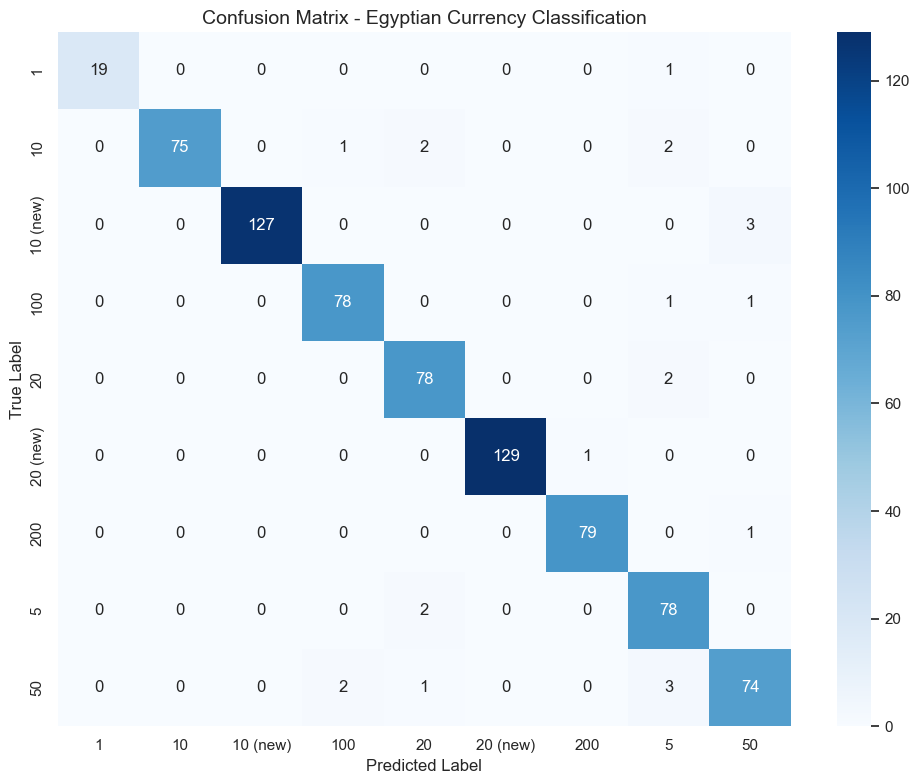


Per-class Accuracy:
  1: 95.0% (19/20)
  10: 93.8% (75/80)
  10 (new): 97.7% (127/130)
  100: 97.5% (78/80)
  20: 97.5% (78/80)
  20 (new): 99.2% (129/130)
  200: 98.8% (79/80)
  5: 97.5% (78/80)
  50: 92.5% (74/80)


In [19]:
def plot_confusion_matrix(y_true, y_pred, class_names):
    """Plot confusion matrix with annotations"""
    cm = confusion_matrix(y_true, y_pred)

    plt.figure(figsize=(10, 8))

    if sns is not None:
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                    xticklabels=class_names, yticklabels=class_names)
    else:
        plt.imshow(cm, interpolation='nearest', cmap='Blues')
        plt.colorbar()
        tick_marks = np.arange(len(class_names))
        plt.xticks(tick_marks, class_names, rotation=45)
        plt.yticks(tick_marks, class_names)

        thresh = cm.max() / 2.
        for i in range(cm.shape[0]):
            for j in range(cm.shape[1]):
                plt.text(j, i, format(cm[i, j], 'd'),
                        horizontalalignment="center",
                        color="white" if cm[i, j] > thresh else "black")

    plt.title('Confusion Matrix - Egyptian Currency Classification', fontsize=14)
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.tight_layout()
    plt.show()

    # Print per-class accuracy
    print("\nPer-class Accuracy:")
    for i, class_name in enumerate(class_names):
        class_correct = cm[i, i]
        class_total = cm[i, :].sum()
        class_acc = class_correct / class_total if class_total > 0 else 0
        print(f"  {class_name}: {class_acc*100:.1f}% ({class_correct}/{class_total})")

plot_confusion_matrix(y_true, y_pred, class_names)


## 15. Example Predictions on Test Images

10/10 ━━━━━━━━━━━━━━━━━━━━ 3s 257ms/step


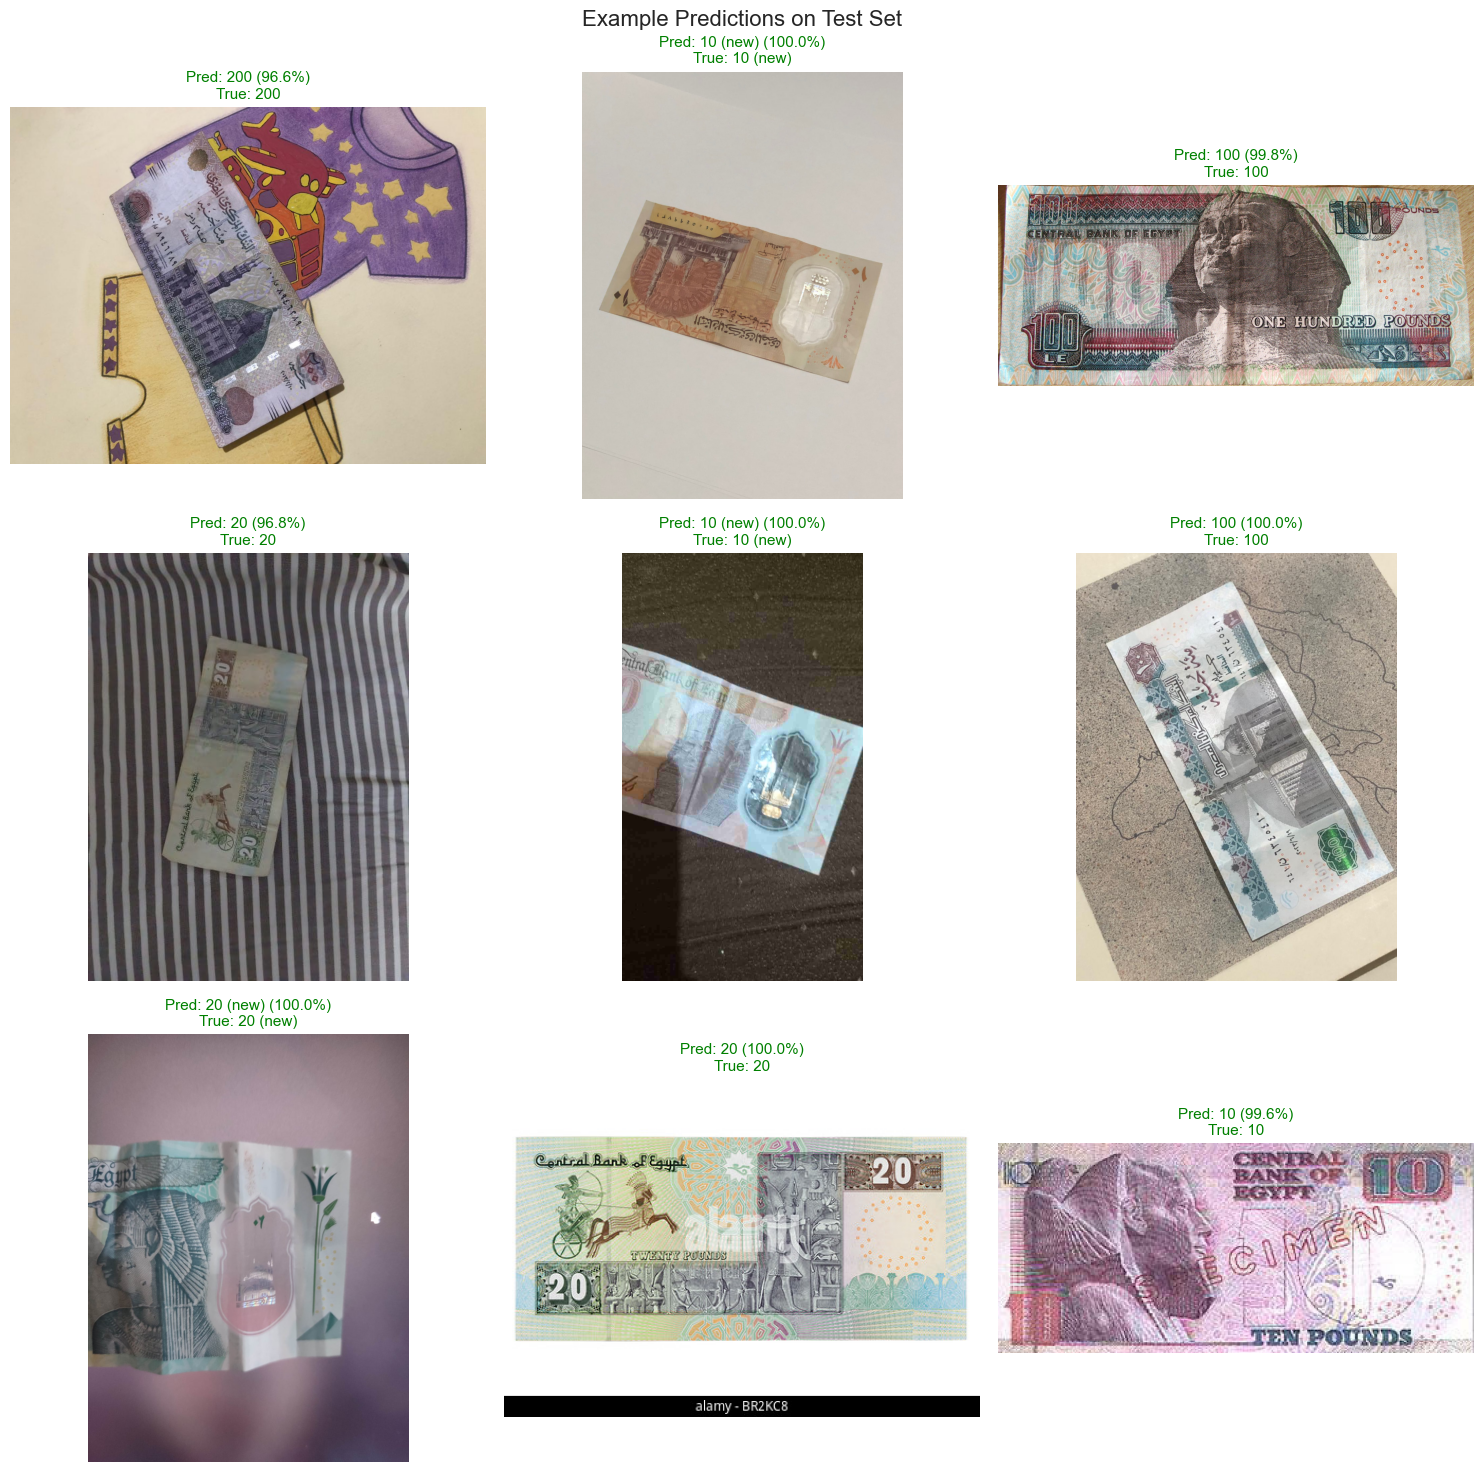

In [20]:
def display_predictions(test_generator, model, class_names, num_samples=9):
    """Display test images with their predictions"""
    try:
        test_files = test_generator.filepaths
    except AttributeError:
        test_files = [os.path.join(test_generator.directory, p) for p in test_generator.filenames]

    # Get predictions
    test_steps = int(ceil(test_generator.samples / BATCH_SIZE))
    test_probs = model.predict(test_generator, steps=test_steps)
    if test_probs.shape[0] > len(test_files):
        test_probs = test_probs[:len(test_files)]

    test_preds = np.argmax(test_probs, axis=1)
    test_true = test_generator.classes

    # Select random samples
    num_samples = min(num_samples, len(test_files))
    indices = np.random.choice(len(test_files), num_samples, replace=False)

    rows = int(np.ceil(num_samples / 3))
    fig, axes = plt.subplots(rows, 3, figsize=(15, rows * 5))
    axes = axes.flatten() if num_samples > 3 else [axes] if num_samples == 1 else axes

    last_idx = 0
    for i, idx in enumerate(indices):
        img_path = str(test_files[idx])
        img = Image.open(img_path).convert('RGB')

        pred_label = class_names[test_preds[idx]]
        true_label = class_names[test_true[idx]]
        confidence = test_probs[idx][test_preds[idx]] * 100

        color = 'green' if pred_label == true_label else 'red'

        axes[i].imshow(img)
        axes[i].set_title(f'Pred: {pred_label} ({confidence:.1f}%)\nTrue: {true_label}',
                         color=color, fontsize=11)
        axes[i].axis('off')
        last_idx = i

    # Hide unused subplots
    for j in range(last_idx + 1, len(axes)):
        axes[j].axis('off')

    plt.suptitle('Example Predictions on Test Set', fontsize=16)
    plt.tight_layout()
    plt.show()

display_predictions(test_generator, model, class_names, num_samples=9)


## 16. Save the Model

In [21]:
# Save the final model
model.save('egyptian_currency_cnn_model.keras')
print("Model saved to 'egyptian_currency_cnn_model.keras'")

# To load the model later:
# from tensorflow.keras.models import load_model
# loaded_model = load_model('egyptian_currency_cnn_model.keras')


Model saved to 'egyptian_currency_cnn_model.keras'


## Summary
- **Model Architecture**: Custom CNN with 3 convolutional blocks (32→64→128 filters) + L2 regularization
- **Regularization**: BatchNormalization + Strong Dropout (0.3-0.4 conv, 0.5 dense) + L2(0.001)
- **Data Augmentation**: Rotation, shifts, zoom, brightness, channel shift (NO horizontal flip)
- **Optimizer**: Adam (lr=0.0005) with ReduceLROnPlateau callback
- **Training**: Up to 100 epochs with EarlyStopping (patience=25)
- **Class Weights**: Computed to handle imbalanced classes
